The shape of the raw_data before scaling is (43800, 5)
Initial shape of x_input (30, 5)
The shape of yhat after prediction is (1, 20, 5)
The new shape of yhat  is (20, 5)
[[  96.08694    19.794289   28.906591 1005.1679     41.048294]
 [  85.39842    20.427547   27.34951  1006.105      35.748024]
 [  89.28282    20.643166   27.045671 1005.7653     34.517445]
 [  92.63185    20.786629   26.48501  1005.8577     29.78845 ]
 [  96.007126   20.842806   25.858883 1005.9783     25.226315]
 [  98.59771    20.906448   25.333996 1006.0689     21.514915]
 [  99.94639    20.946428   24.975773 1006.1115     18.270235]
 [ 100.65701    20.93824    24.860811 1006.14264    15.740538]
 [ 101.0127     20.861717   25.064522 1006.16455    14.113768]
 [ 101.12274    20.70508    25.648918 1006.1736     13.503461]
 [ 100.973335   20.457119   26.662855 1006.1635     13.972997]
 [ 100.46332    20.108421   28.143318 1006.12714    15.544532]
 [  98.26932    19.900505   29.697289 1005.99243    16.181524]
 [  95.443

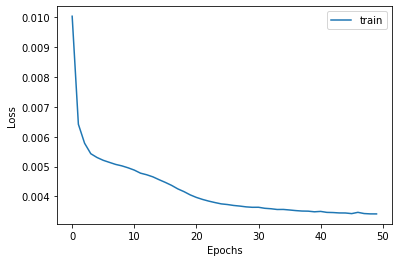

In [1]:
# multivariate output stacked lstm example
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
data = read_csv('pollution2.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 40000
#dataset = raw_data[0:n_train,:]
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
n_steps_in, n_steps_out = 30, 20
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(30, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(30, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=50, verbose=0, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()